In [1]:
import sys
import os
import glob
sys.path.append('../..')

from model import processing
price_list = processing.import_binance_prices(start_date='Nov 1 2022', assets=['DOT', 'BTC', 'ETH', 'DOGE'], days=30)

In [2]:
from pprint import pprint
import random
import sys
from matplotlib import pyplot as plt
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, dynamicadd_asset_fee, dynamicadd_lrna_fee
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.20},
    'BTC': {'usd price': price_list[0]['BTC'], 'weight': 0.20},
    'ETH': {'usd price': price_list[0]['ETH'], 'weight': 0.20},
    'DOT': {'usd price': price_list[0]['DOT'], 'weight': 0.20},
    'DOGE': {'usd price': price_list[0]['DOGE'], 'weight': 0.10}
}

lrna_price_usd = 0.07
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            lrna_fee=dynamicadd_lrna_fee(
                minimum=0.0025, 
                amplification=0.9166666666666667, 
                decay=5e-06,
                fee_max=0.015625,
                raise_oracle_name='fee_raise',
            ),
            oracles={'fee_raise': 11},  # , 'fee_lower': 7200},
            asset_fee=dynamicadd_asset_fee(
                minimum=0.0025,
                amplification=2, 
                decay=6.17283950617284e-06,
                fee_max=0.5,
                raise_oracle_name='fee_raise'
            )
        )
    },
    agents = {
        'Trader': Agent(
            holdings={tkn: 100000000 for tkn in list(assets.keys()) + ["LRNA"]},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool',
                arb_precision=3
            )
            # price_sensitive_trading(
            #     max_volume_usd=50,
            #     pool_id='omnipool',
            #     price_sensitivity=25,
            #     trade_frequency=2
            # )  # + 
        ),
        'LP': Agent(
            holdings={tkn: liquidity[tkn] / 10 for tkn in assets},
            trade_strategy=invest_all('omnipool')
        )
    },
    evolve_function=historical_prices(price_list),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    archive_all=False
)
time_steps = len(price_list)-1
print(f'Running with {time_steps} time steps')
events = run.run(initial_state, time_steps=time_steps)
# events = processing.postprocessing(events, optional_params=['withdraw_val'])

Running with 215872 time steps
Starting simulation...
Execution time: 30.093 seconds.


<AxesSubplot:title={'center':'asset price: DOT '}>

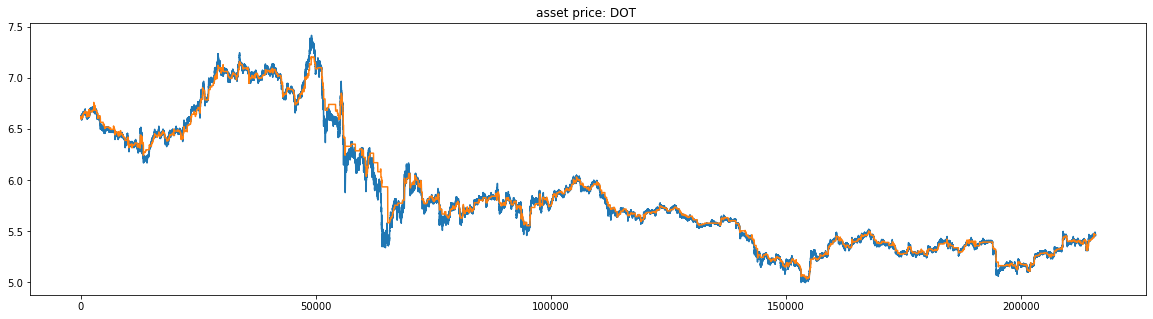

In [3]:
ax = pu.plot(events, asset='DOT') 
pu.plot(events, pool='omnipool', prop='usd_price', key='DOT', subplot=ax)

In [4]:
processing.save_output(filename='best_dynamic_fees', data=events)

:::FEES:::


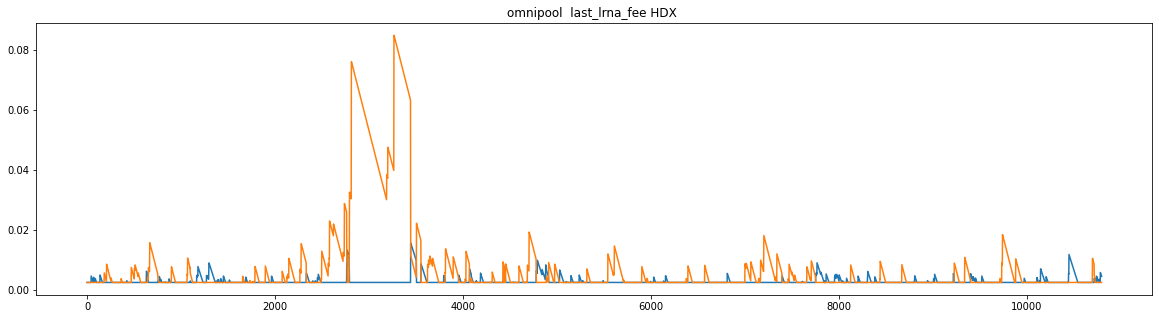

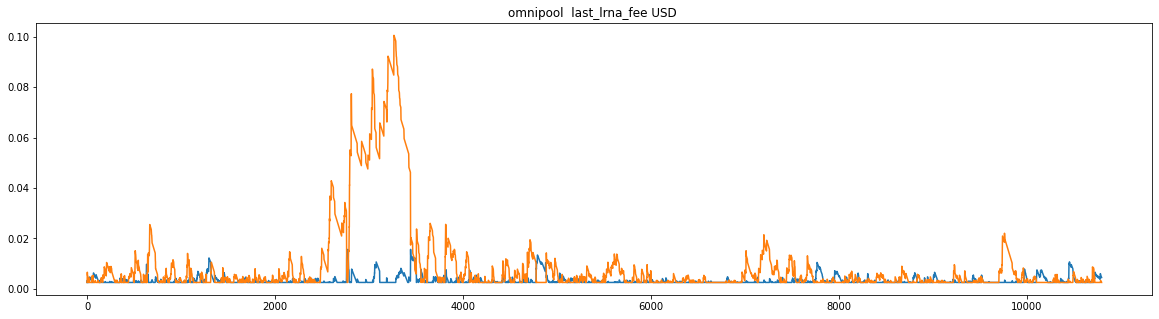

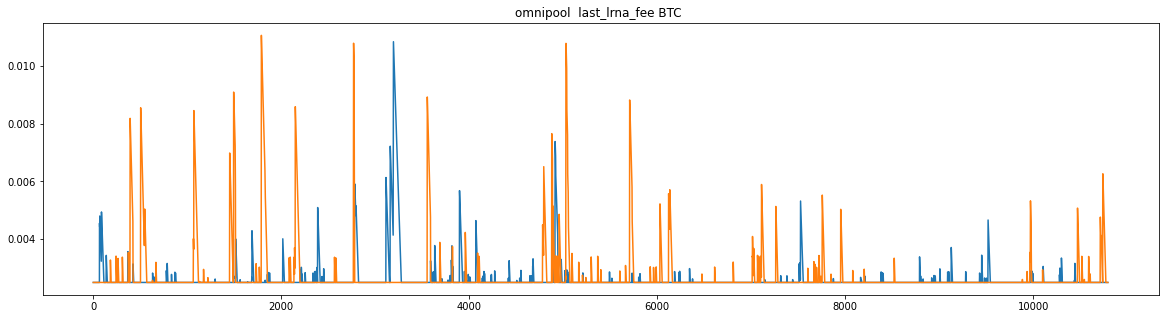

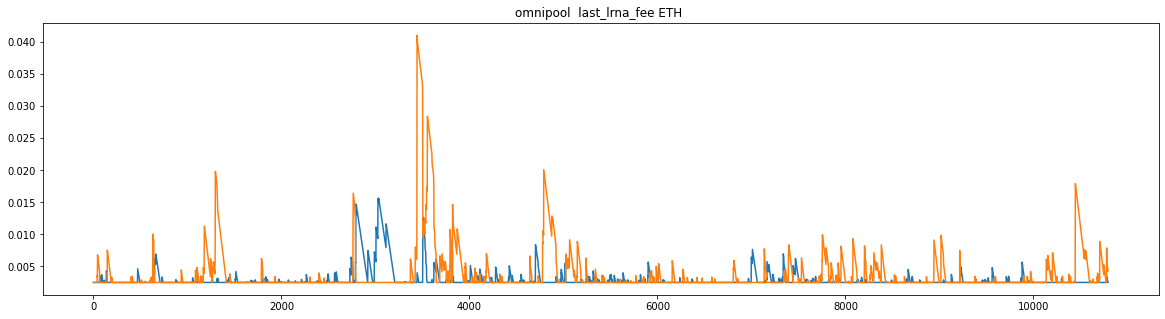

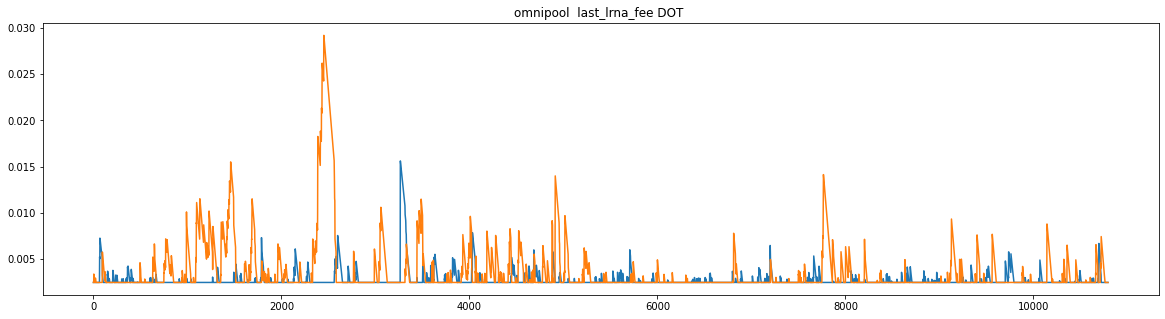

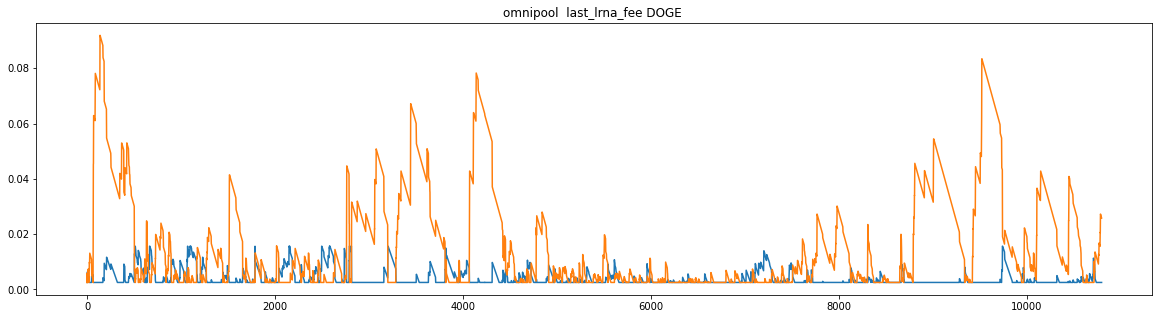

In [5]:
# print(events[0])
# dynamic_mult = [events[i]['state'].pools['omnipool'].last_mult for i in range(len(events))]
# plt.plot(range(len(dynamic_mult)), dynamic_mult)
# print(initial_state.pools['omnipool'].asset_list)
print(":::FEES:::")
# asset_fee = pu.get_datastream(events, pool='omnipool', prop='asset_fee', key='all')  # {tkn: [event['asset_fee'][tkn] for event in events[10:]] for tkn in assets}
# lrna_fee = pu.get_datastream(events, pool='omnipool', prop='lrna_fee', key='all')  # {tkn: [event['lrna_fee'][tkn] for event in events[10:]] for tkn in assets}
# print(lrna_fee['HDX'][1])
for tkn in initial_state.pools['omnipool'].asset_list:
    # print(tkn)
    # plt.figure(figsize=(20, 5))
    ax = pu.plot(events[::20], pool='omnipool', prop='last_lrna_fee', key=tkn)
    pu.plot(events[::20], pool='omnipool', prop='last_fee', key=tkn, subplot=ax)
    # plt.title(tkn)

In [6]:
# basic_state = initial_state.copy()
# basic_state.pools['omnipool'].lrna_fee = 0.0005
# basic_state.pools['omnipool'].asset_fee = 0.0025

no_arb_state = initial_state.copy()
no_arb_state.agents['Trader'].trade_strategy=price_sensitive_trading(
    max_volume_usd=150,
    pool_id='omnipool',
    price_sensitivity=50,
    trade_frequency=0.5
)

events2 = run.run(no_arb_state, time_steps=time_steps)
# events2 = processing.postprocessing(events2, optional_params=['withdraw_val'])

# print(events2[-1])
# feeless_arbitrageur = events2[-1]['state'].agents['Arbitrageur']

Starting simulation...
Execution time: 19.149 seconds.


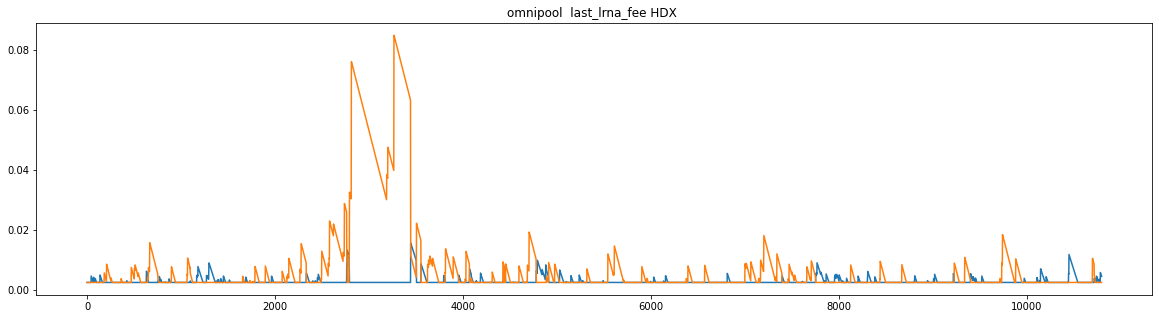

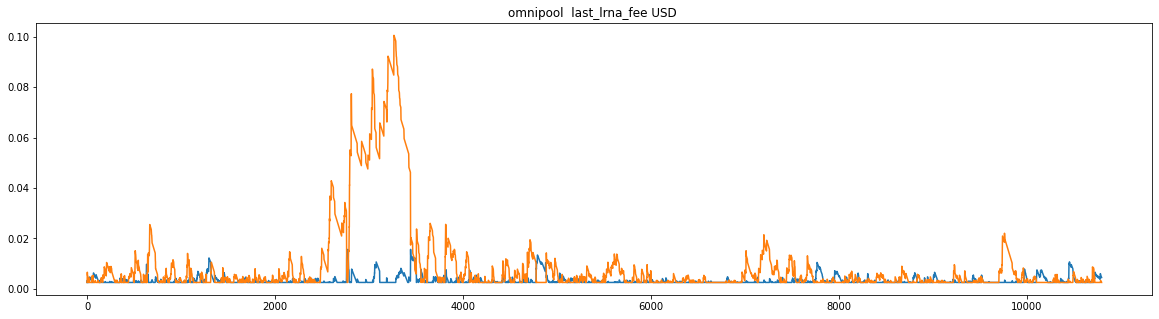

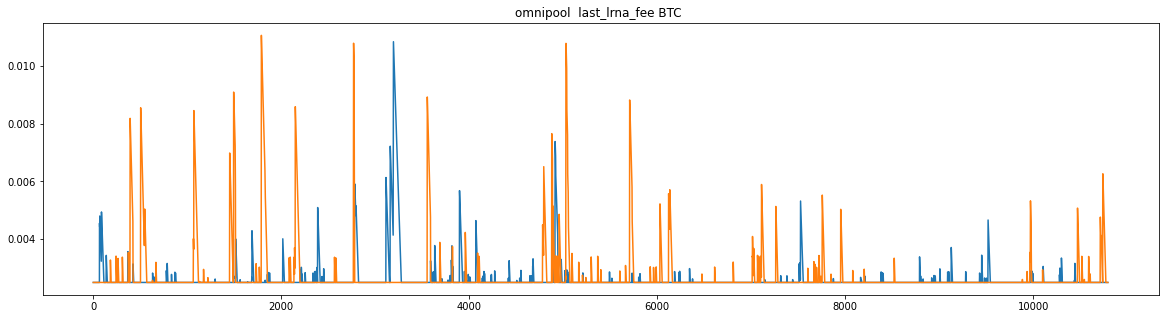

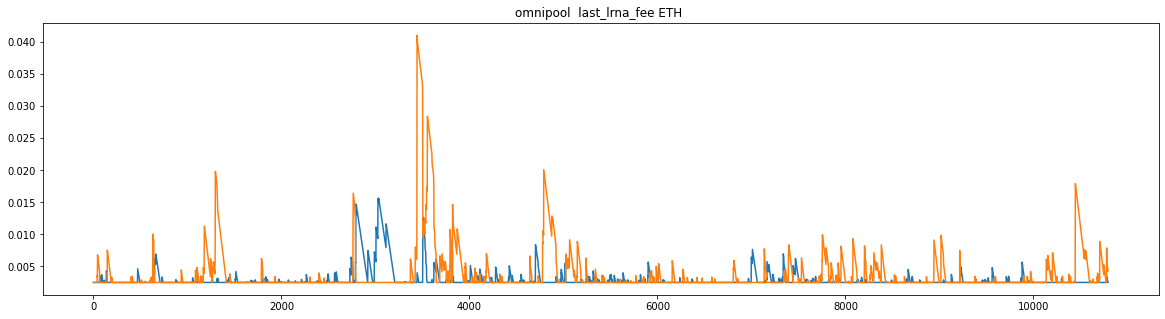

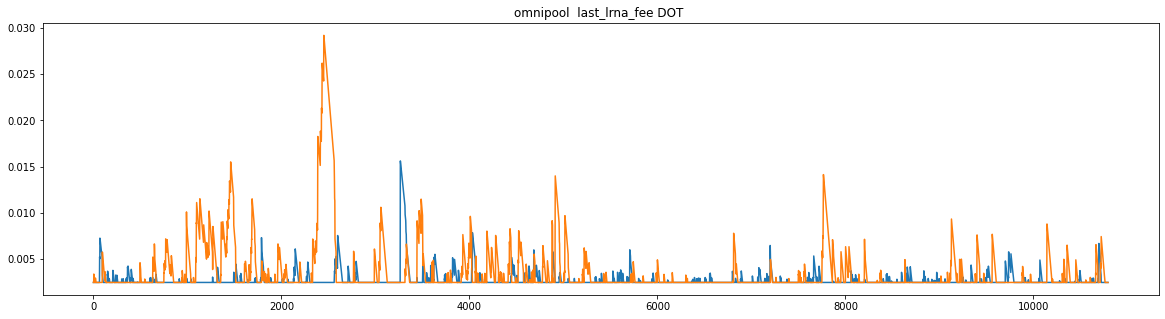

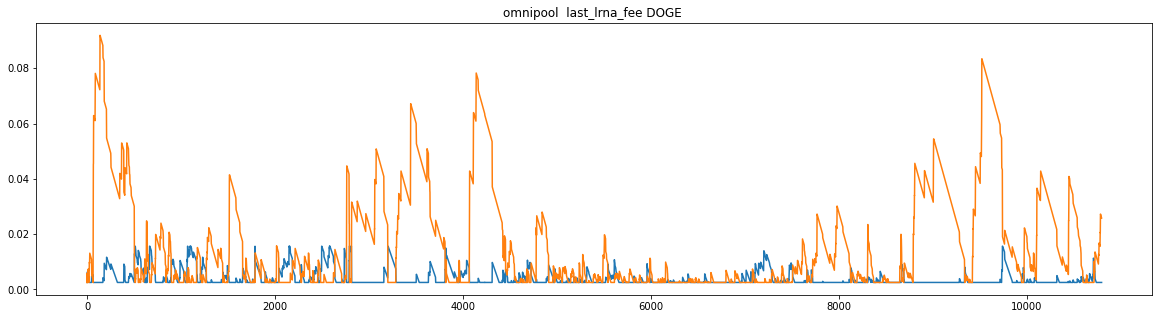

In [7]:
for tkn in initial_state.pools['omnipool'].asset_list:
    # print(tkn)
    # plt.figure(figsize=(20, 5))
    ax = pu.plot(events[::20], pool='omnipool', prop='last_lrna_fee', key=tkn)
    pu.plot(events[::20], pool='omnipool', prop='last_fee', key=tkn, subplot=ax)
    # plt.title(tkn)

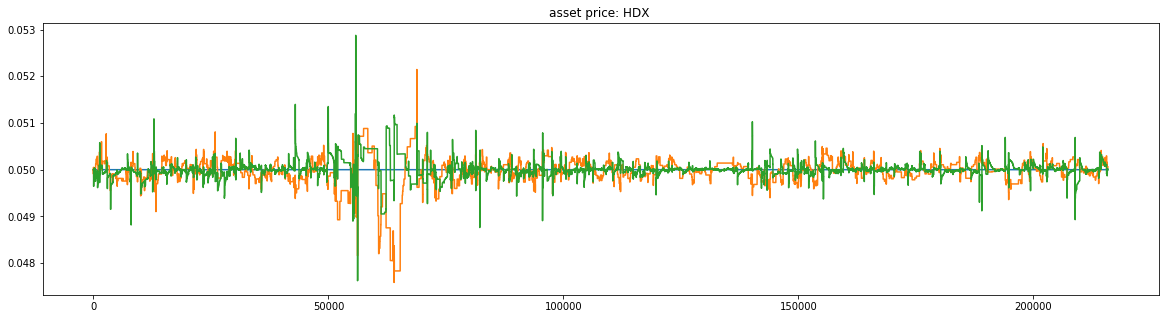

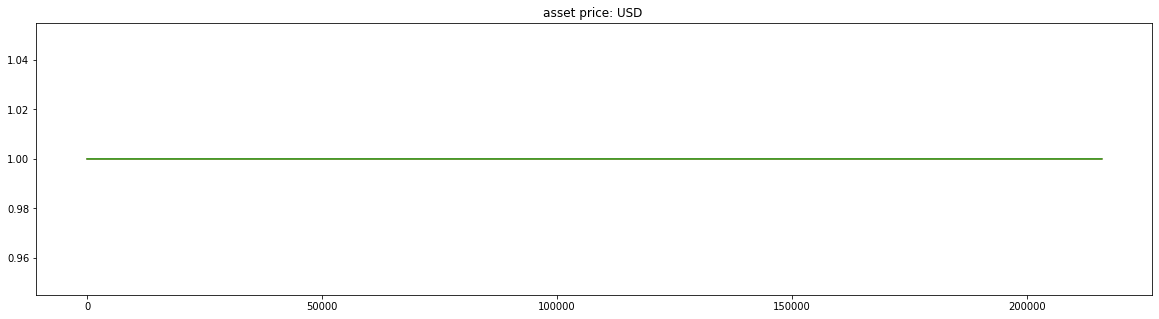

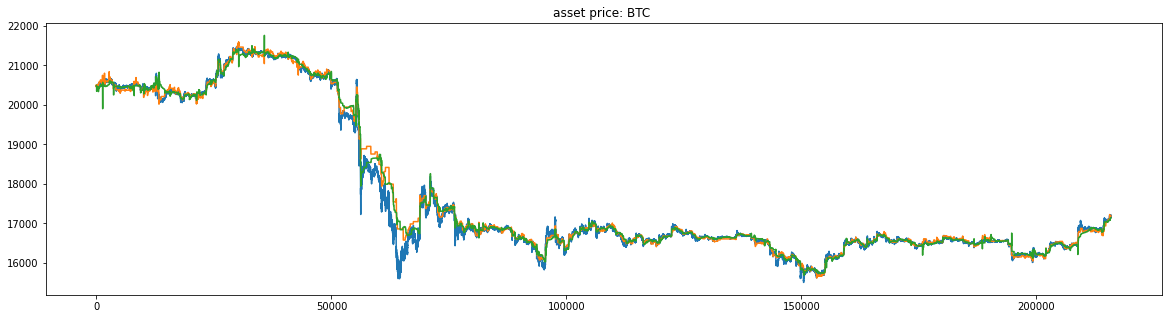

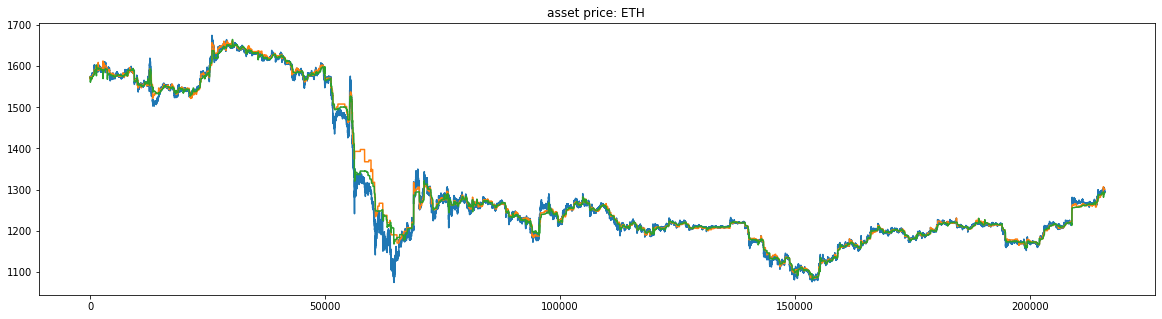

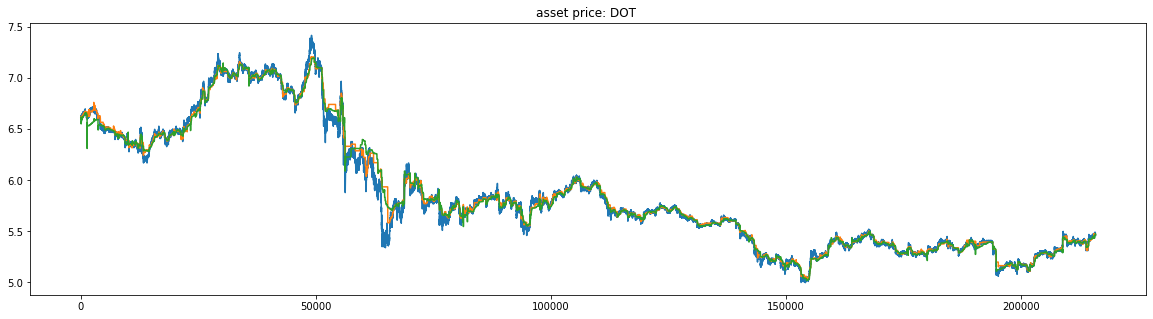

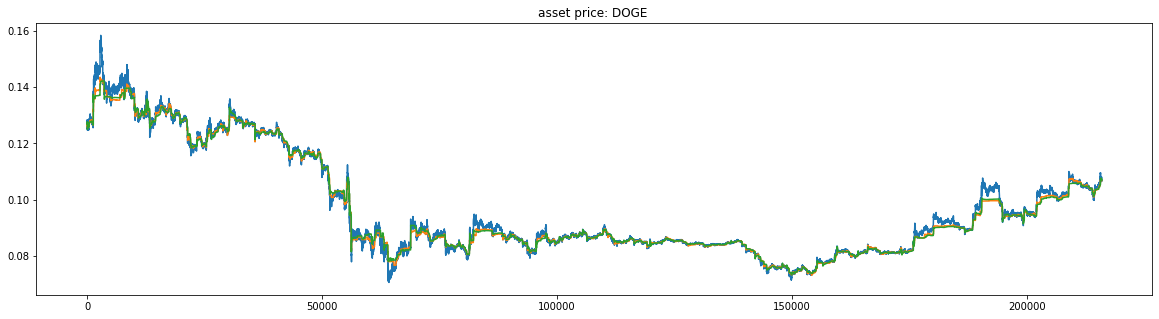

In [8]:
# lp_with_fees = pu.get_datastream(events, 'LP returns')
# lp_no_fees = pu.get_datastream(events2, 'LP returns')
# ax = pu.plot(events, agent='LP', prop='cash_out')
# pu.plot(events2, agent='LP', prop='cash_out', subplot=ax)
# plt.title('LP with dynamic fees (blue) vs 0.25% flat (orange)')
for tkn in assets:
    ax = pu.plot(events, asset=tkn) 
    pu.plot(events, pool='omnipool', prop='usd_price', key=tkn, subplot=ax)
    pu.plot(events2, pool='omnipool', prop='usd_price', key=tkn, subplot=ax)

In [9]:
# print(events[0], events[1000])

In [10]:
from model.amm.omnipool_amm import cash_out_omnipool
# print(cash_out_omnipool(events[0].pools['omnipool'], events[-1].agents['LP'], events[-1].external_market))
print(cash_out_omnipool(events[-1].pools['omnipool'], events[-1].agents['LP'], events[-1].external_market))
print(cash_out_omnipool(events2[-1].pools['omnipool'], events2[-1].agents['LP'], events2[-1].external_market))

866169.6510521732
867005.7922252943


In [11]:
static_fee_state = initial_state.copy()
static_fee_state.pools['omnipool'].asset_fee = 0.0025
static_fee_state.pools['omnipool'].lrna_fee = 0.0005


static_fee_events = run.run(static_fee_state, time_steps=time_steps)

Starting simulation...
Execution time: 32.129 seconds.


In [12]:
static_fee_no_arb_state = initial_state.copy()
static_fee_no_arb_state.pools['omnipool'].asset_fee = 0.0025
static_fee_no_arb_state.pools['omnipool'].lrna_fee = 0.0005
static_fee_no_arb_state.agents['Trader'].trade_strategy = price_sensitive_trading(
    max_volume_usd=150,
    pool_id='omnipool',
    price_sensitivity=50,
    trade_frequency=1
)

static_fee_no_arb_events = run.run(static_fee_no_arb_state, time_steps=time_steps)

Starting simulation...
Execution time: 15.561 seconds.


In [13]:
no_fee_state = initial_state.copy()
no_fee_state.pools['omnipool'].asset_fee = 0
no_fee_state.pools['omnipool'].lrna_fee = 0


events3 = run.run(no_fee_state, time_steps=time_steps)

Starting simulation...
Execution time: 81.147 seconds.


In [14]:
no_fee_no_arb_state = initial_state.copy()
no_fee_no_arb_state.pools['omnipool'].asset_fee = 0
no_fee_no_arb_state.pools['omnipool'].lrna_fee = 0
no_fee_no_arb_state.agents['Trader'].trade_strategy = price_sensitive_trading(
    max_volume_usd=150,
    pool_id='omnipool',
    price_sensitivity=50,
    trade_frequency=1
)

events4 = run.run(no_fee_no_arb_state, time_steps=time_steps)

Starting simulation...
Execution time: 17.534 seconds.


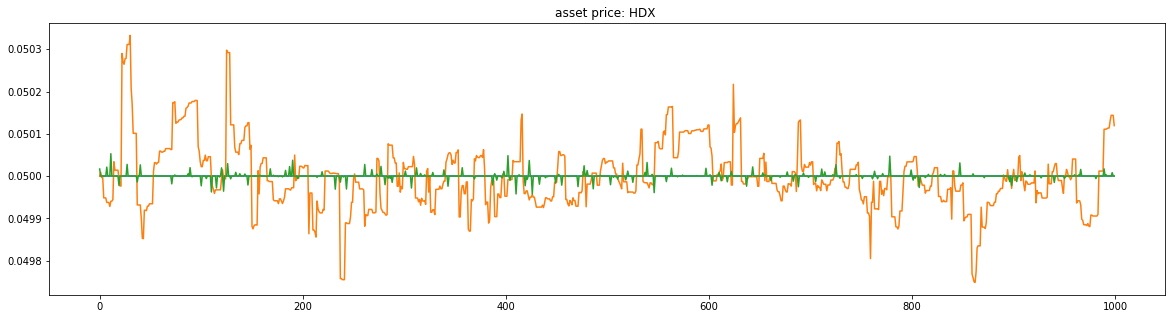

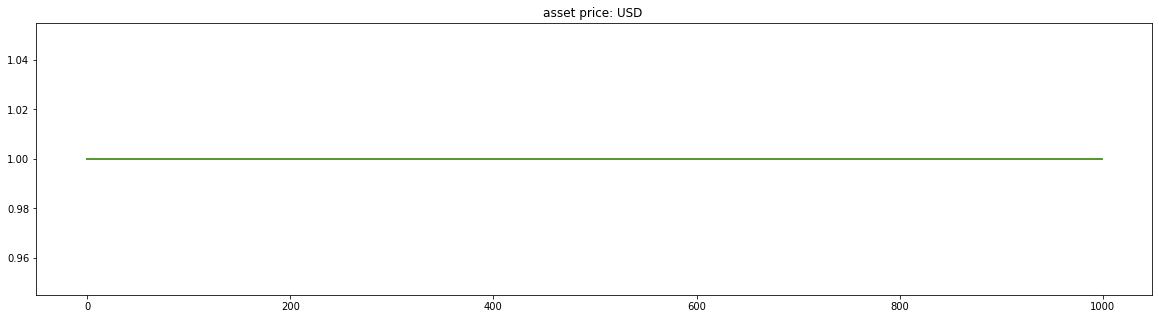

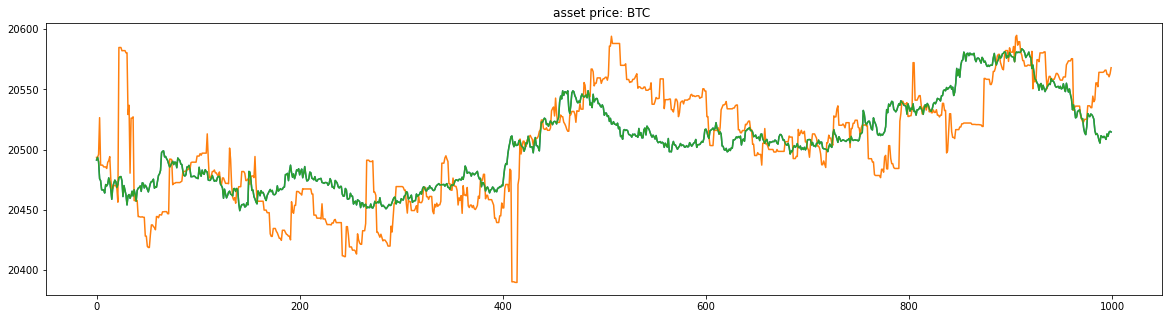

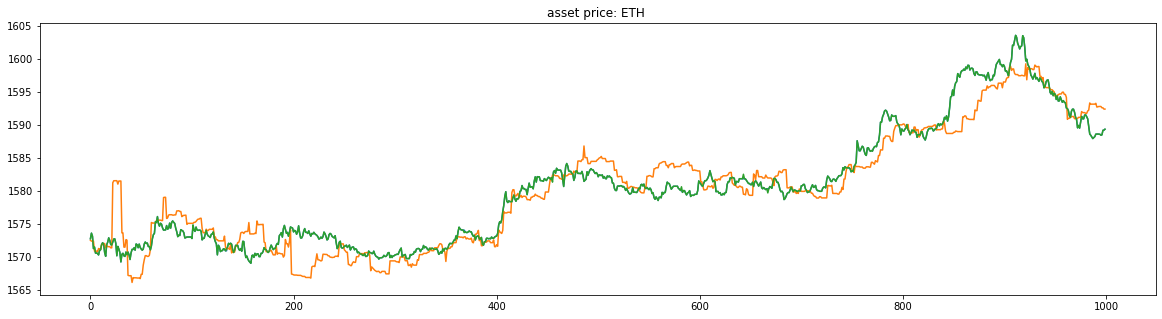

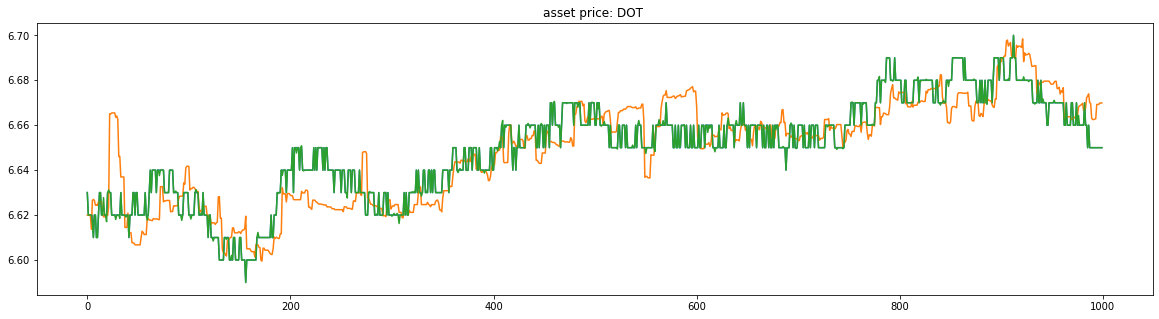

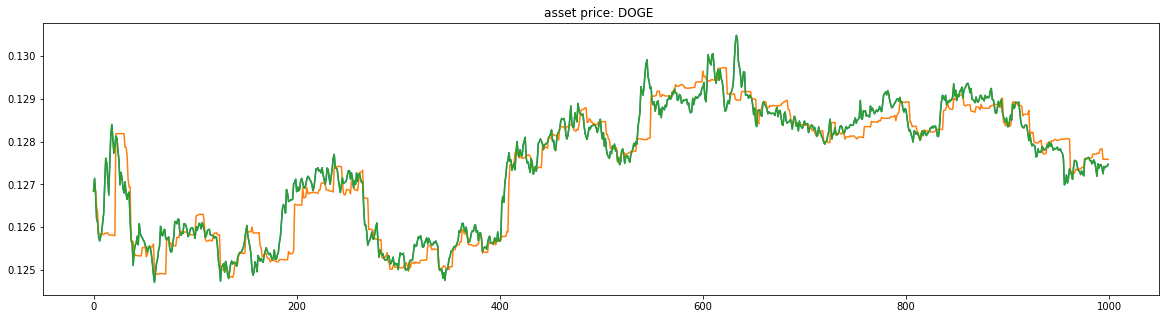

In [15]:
for tkn in assets:
    ax = pu.plot(events3[:1000], asset=tkn) 
    pu.plot(events4[:1000], pool='omnipool', prop='usd_price', key=tkn, subplot=ax)
    pu.plot(events3[:1000], pool='omnipool', prop='usd_price', key=tkn, subplot=ax)
    

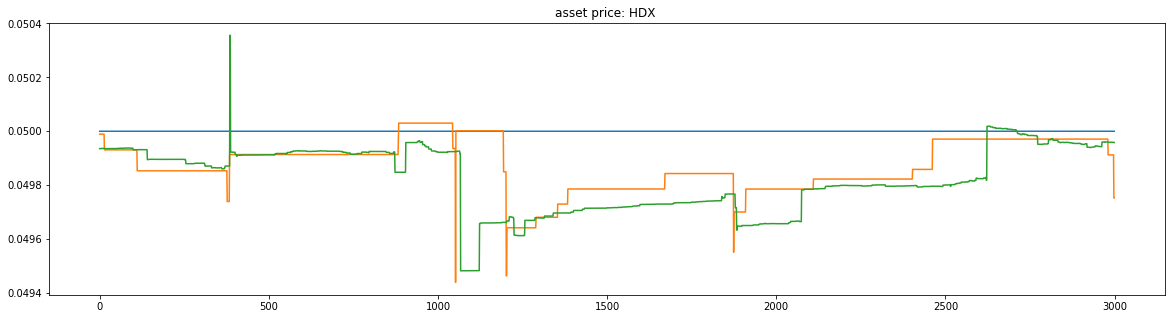

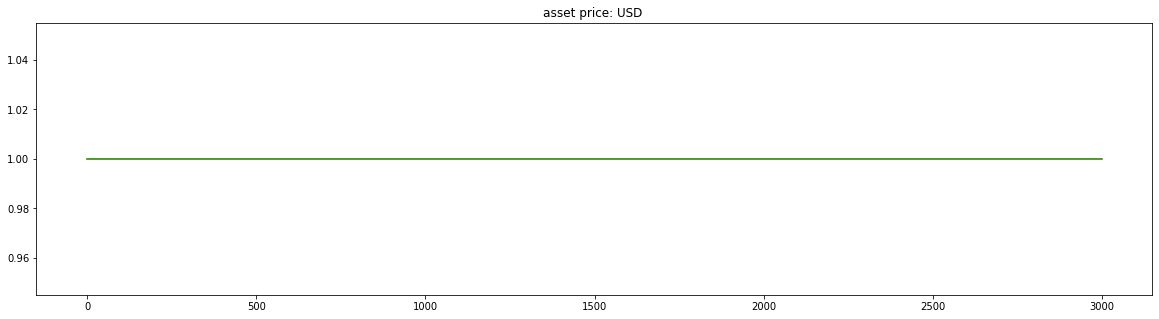

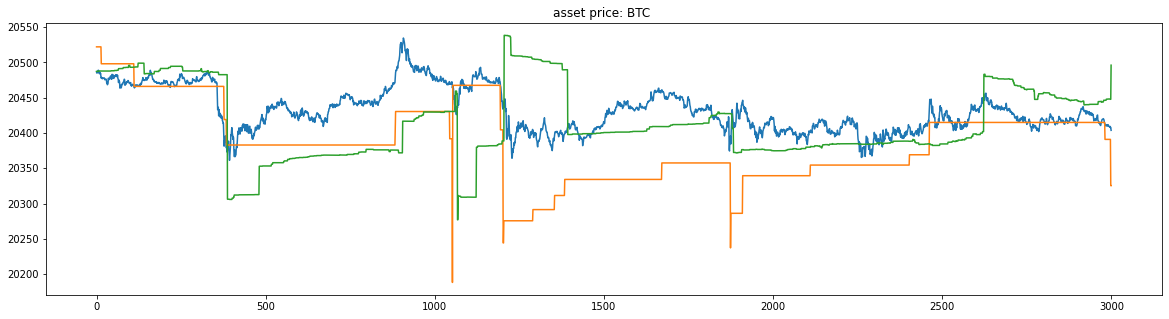

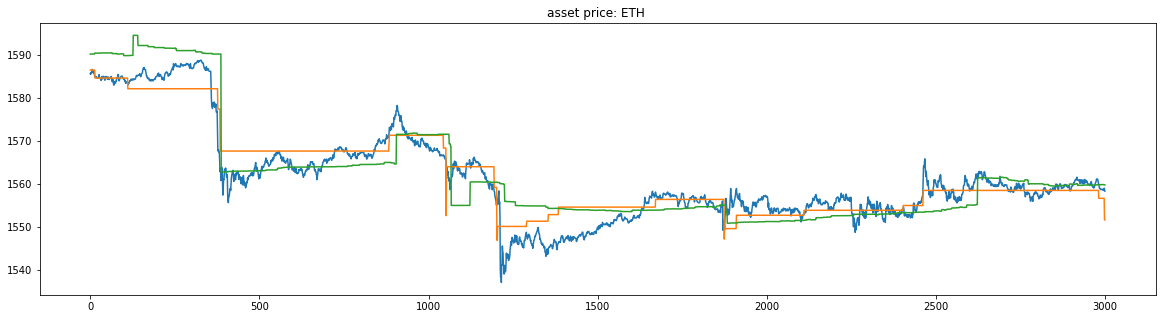

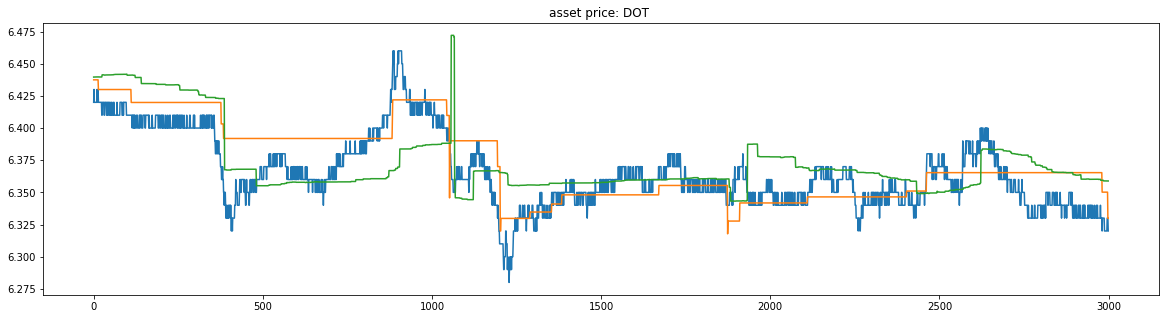

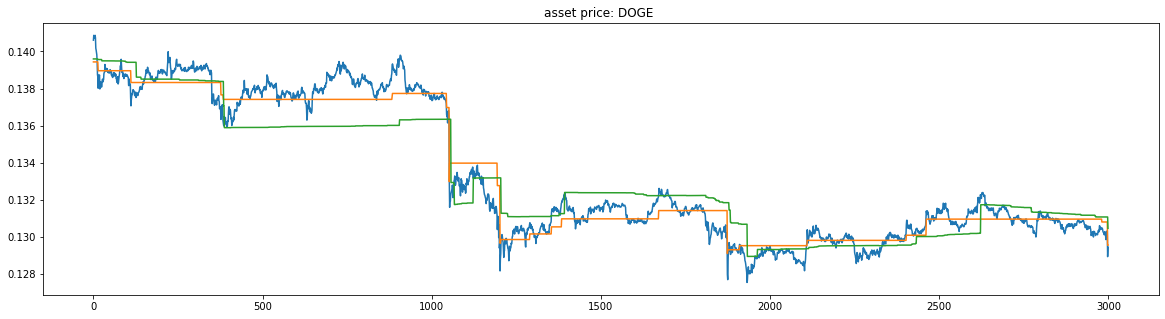

In [16]:
for tkn in assets:
    ax = pu.plot(events3[9000:12000], asset=tkn) 
    pu.plot(events[9000:12000], pool='omnipool', prop='usd_price', key=tkn, subplot=ax)
    pu.plot(events2[9000:12000], pool='omnipool', prop='usd_price', key=tkn, subplot=ax)
    

In [19]:
LP_starting_cash = cash_out_omnipool(events[0].pools['omnipool'], events[0].agents['LP'], events[-1].external_market)
print('LP starting cash at end-of-run prices:', LP_starting_cash)
print('LP profits vs just holding cash:')
print('arbitrage, dynamic fees:', cash_out_omnipool(events[-1].pools['omnipool'], events[-1].agents['LP'], events[-1].external_market) - LP_starting_cash)
print('pseudo-arbitrage, dynamic fees:', cash_out_omnipool(events2[-1].pools['omnipool'], events2[-1].agents['LP'], events2[-1].external_market) - LP_starting_cash)
print('arbitrage, static fees:', cash_out_omnipool(events3[-1].pools['omnipool'], static_fee_events[-1].agents['LP'], static_fee_events[-1].external_market) - LP_starting_cash)
print('pseudo-arbitrage, static fees:', cash_out_omnipool(events4[-1].pools['omnipool'], static_fee_no_arb_events[-1].agents['LP'], static_fee_no_arb_events[-1].external_market) - LP_starting_cash)
print('arbitrage, zero fees:', cash_out_omnipool(events3[-1].pools['omnipool'], events3[-1].agents['LP'], events3[-1].external_market) - LP_starting_cash)
print('pseudo-arbitrage, zero fees:', cash_out_omnipool(events4[-1].pools['omnipool'], events4[-1].agents['LP'], events4[-1].external_market) - LP_starting_cash)

LP starting cash at end-of-run prices: 881295.7962344147
LP profits vs just holding cash:
arbitrage, dynamic fees: -15126.145182241453
pseudo-arbitrage, dynamic fees: -14290.0040091204
arbitrage, static fees: -18880.726199954865
pseudo-arbitrage, static fees: -18942.951874814695
arbitrage, zero fees: -18913.37728290551
pseudo-arbitrage, zero fees: -18936.97180670686


In [20]:
trader_starting_cash = cash_out_omnipool(events[0].pools['omnipool'], events[0].agents['Trader'], events[-1].external_market)
print('Trader starting cash at end-of-run prices:', trader_starting_cash)
print('Trader profits vs just holding cash:')
print('arbitrage, dynamic fees:', cash_out_omnipool(events[-1].pools['omnipool'], events[-1].agents['Trader'], events[-1].external_market) - trader_starting_cash)
print('pseudo-arbitrage, dynamic fees:', cash_out_omnipool(events2[-1].pools['omnipool'], events2[-1].agents['Trader'], events2[-1].external_market) - trader_starting_cash)
print('arbitrage, static fees:', cash_out_omnipool(events3[-1].pools['omnipool'], static_fee_events[-1].agents['Trader'], static_fee_events[-1].external_market) - trader_starting_cash)
print('pseudo-arbitrage, static fees:', cash_out_omnipool(events4[-1].pools['omnipool'], static_fee_no_arb_events[-1].agents['Trader'], static_fee_no_arb_events[-1].external_market) - trader_starting_cash)
print('arbitrage, zero fees:', cash_out_omnipool(events3[-1].pools['omnipool'], events3[-1].agents['Trader'], events3[-1].external_market) - trader_starting_cash)
print('pseudo-arbitrage, zero fees:', cash_out_omnipool(events4[-1].pools['omnipool'], events4[-1].agents['Trader'], events4[-1].external_market) - trader_starting_cash)

Trader starting cash at end-of-run prices: 1846473679000.0002
Trader profits vs just holding cash:
arbitrage, dynamic fees: -42628.086669921875
pseudo-arbitrage, dynamic fees: -60062.143310546875
arbitrage, static fees: -44835.986328125
pseudo-arbitrage, static fees: -38175.718505859375
arbitrage, zero fees: 18328.589599609375
pseudo-arbitrage, zero fees: 18321.147216796875
